# PIPS 0.3.0 tests

In [1]:
import PIPS
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
PIPS.__version__

'0.3.0-alpha.6'

## data prep

In [3]:
data = PIPS.data_readin_LPP('sample_data/005.dat',filter='V')
x,y,yerr=data

star  = PIPS.photdata(data) # the most basic way to initialize object
star2 = PIPS.photdata(data,label='Star2',band='V') # same as star1, but with more info

In [4]:
# basic information check
print('* Basic information check')
print(star)              # the basic information
print(star2)             # the basic information -- label and filter info is included
print(len(star))         # number of datapoints
print(star == star2)     # two objects are identical (hash-equality)

# manipulate data
print('\n* Data manipulation')
star2.cut(yerr_min=0.01)  # cuts data (based on x, y, and yerr values)
print(star2)              # now data is shorter
print(star == star2)      # but still identical -- raw data is internally preserved 

# more!
print('\n* More!')
star3 = star + star2     # data concatenation (returns another photdata object)
star3.label = 'Star3'    # always add labels
print(star3)             # star3 has more datapoints (notice cuts are applied to star2)
print(star == star3)     # once the data itself is changed, they are not identical

# also...
print('\n* also...')
star4 = star3.copy()    # creates a copy of star3 (including all attributes)
star4.x[-1] = 0         # manually change the data (don't do this!)
print(star == star4)    # now that the data itself is changed, they are not identical

* Basic information check
Photdata : band=None, size=103, period=None
Photdata Star2: band=V, size=103, period=None
103
True

* Data manipulation
Photdata Star2: band=V, size=75, period=None
True

* More!
Photdata Star3: band=None, size=178, period=None
False

* also...
False


# tests

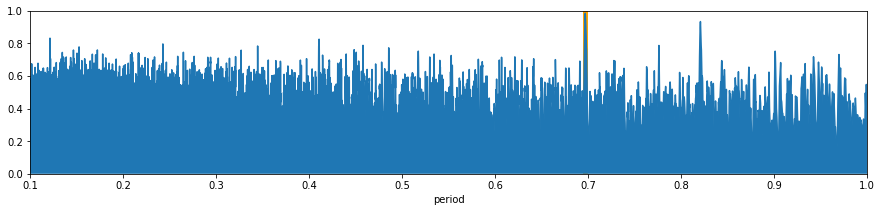

[0.6968815]


In [5]:
# periodogram test
periods,power = star.periodogram(p_min=0.1,p_max=1,multiprocessing=True)

# plot
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

In [78]:
period  = 0.2
size = 50
x_th = np.random.choice(np.linspace(1,300,10000),size)
y_th = 2 * np.sin(2*np.pi*x_th/period) + np.random.uniform(0,2,x_th.shape) + 10
y_err = np.ones_like(y_th) * 0.1
test = PIPS.photdata([x_th,y_th,y_err])
periods,power = test.periodogram(p_min=0.1,p_max=period+1)

(0.1998266916873153, 0.20017330831268473)

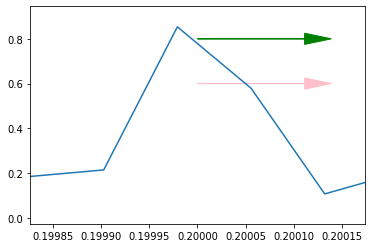

In [81]:
T = (x_th.max()-x_th.min())
f = 1/period
Df = 1/T
width = Df/(f**2-Df**2/4)
width3 = period**2 *T / (T**2-0.25)

plt.plot(periods,power)
plt.arrow(period,0.8,width,0,head_width=0.05,head_length=width/5,
          color='green',alpha=1,length_includes_head=True)
plt.arrow(period,0.6,width3,0,head_width=0.05,head_length=width3/5,
          color='pink',alpha=1,length_includes_head=True)
W = np.max([width,width3])+np.max([width,width3])/4
plt.xlim(period-W,period+W)

In [61]:
width

0.031364607504287115

$$\frac{1}{T} / \left(f-\frac{1}{T^2}\right) = \frac{1}{T} / \frac{T^2f-1}{T^2} = \frac{1}{T}\cdot\frac{T^2}{T^2f-1} = \frac{T}{T^2f-1}$$

$P_2 - P_1 = 1/f_2 - 1/f_1 = \frac{f_1-f_2}{f_1f_2}$

$ f_1 = f - \Delta f/2$

$f_2 = f + \Delta f/2$

$\Delta P = \frac{2\Delta f}{f^2 - \Delta f^2}$

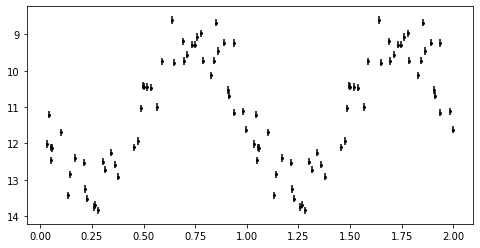

In [31]:
test.plot_lc(period)

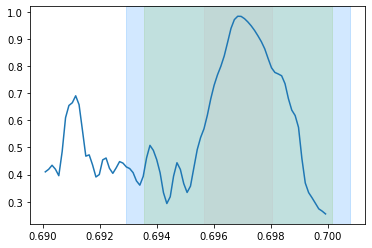

In [14]:
cut = (periods>0.69) & (periods<0.70)
plt.plot(periods[cut],power[cut])
peak = 0.69683711
width = np.log(1/peak)/(x.max()-x.min())
width2 = 1/(x.max()-x.min())
width3 = np.log(abs(peak-1))/(x.max()-x.min())

plt.axvspan(peak-width/2,peak+width/2,alpha=0.2,color='pink')
plt.axvspan(peak-width2/2,peak+width2/2,alpha=0.2,color='yellowgreen')
plt.axvspan(peak-width3/2,peak+width3/2,alpha=0.2,color='dodgerblue')


In [9]:
width

-0.002379664472181124

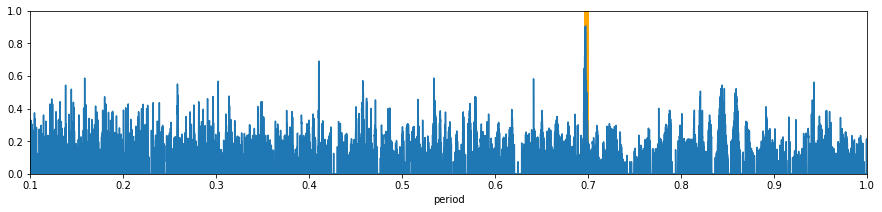

[0.69731154]
20.645 sec.


In [4]:
# periodogram test w/ Gaussian
t0 = time.time()
periods,power = star.periodogram(p_min=0.1,p_max=1,method='custom',model='Gaussian',multiprocessing=False,Nterms=1,maxfev=100)
tf = time.time()

# plot
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])
print(f'{tf-t0:.3f} sec.')

In [3]:
from numba import njit
@njit
def polynomial(x,period,params,arg1,arg2=2):
    mod = np.remainder(x,period)
    return params[0] + params[1]*(mod-params[3])**arg1 + params[2]*(mod-params[4])**arg2

def poly_p0(x,y,yerr,period,**kwargs):
    return [np.mean(y),1,1,period/2,period/2]

17.933 sec.


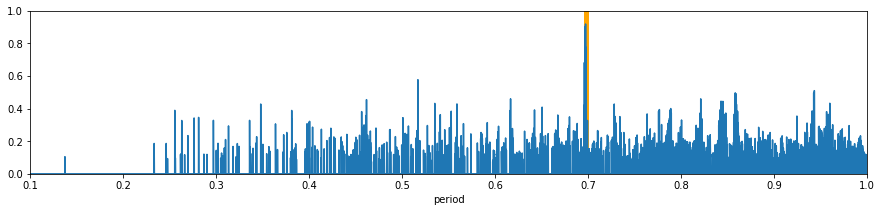

[0.69731154]


In [4]:
# periodogram test w/ custom function
t0 = time.time()
periods,power = star.periodogram(
                    p_min=0.1,
                    p_max=1,
                    method='custom',
                    model=polynomial,
                    p0_func=poly_p0,
                    multiprocessing=False,
                    arg1=1,
                    arg2=4,
                    maxfev=100)
tf = time.time()
print(f'{tf-t0:.3f} sec.')

# plot
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

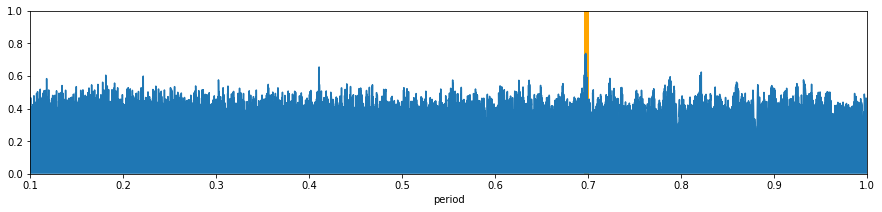

[0.69743015]


In [6]:
# periodogram test w/ Gaussian
periods,power = star.periodogram(p_min=0.1,p_max=1,method='fast',model='Gaussian',Nterms=1,multiprocessing=False)

# plot
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

In [6]:
# period detection test
star.get_period(p_min=0.1,p_max=1.,debug=True,method='custom',model='Gaussian',Nterms=1,p=1)

0.000s --- starting the process...
0.000s --- preparing data...
0.000s --- getting a periodogram...
9.054s --- detecting top 5 peaks...
9.056s --- preparing for finer sampling near peaks...
9.058s --- performing finer sampling near peaks...
13.802s --- period candidate:  0.6972455309893922
14.954s --- estimating the uncertainty...
14.957s --- period candidate:  0.6972455309893922
14.957s --- period fitted*:  0.6972492776819702
14.957s --- period error:  4.261505199200112e-08
14.957s --- refining samples...
14.957s --- refining search width = 6.588e-04
15.575s --- period candidate:  0.6968732145413092
15.575s --- period fitted*:  0.6968769334308296
15.576s --- period error:  0.0001262175730778084
15.576s --- * validating period error...
15.576s --- * fitted period - peak period = 3.72e-06
15.576s --- * expected deviation size = 1.26e-04
15.576s --- * period error validated
15.576s --- period = 0.69687 +- 0.00013d
15.580s --- process completed.


(0.6968732145413092, 0.0001262175730778084)

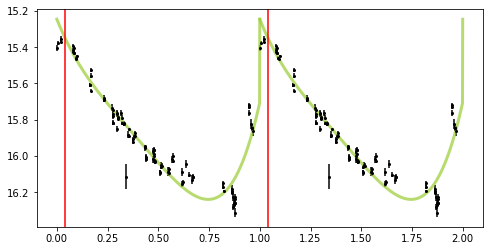

In [8]:
# auto plotting & best-fit curve generation & epoch detection test
star = PIPS.photdata([x-0.2,y,yerr])
star.get_period(p_min=0.1,p_max=1,model=polynomial,method='custom',p0_func=poly_p0,arg1=1,arg2=4)
star.plot_lc()
x_th,y_th = star.get_bestfit_curve(period=star.period,model=polynomial,p0_func=poly_p0,arg1=1,arg2=4)
epoch_offset = star.get_epoch_offset() # the epoch offset in the unit of [days] (not normalized to phase)

# plot
plt.plot(x_th/star.period,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.plot(x_th/star.period+1,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.axvline(epoch_offset/star.period,color='red')
plt.axvline(epoch_offset/star.period+1,color='red')

In [ ]:
# auto plotting & best-fit curve generation & epoch detection test
star.plot_lc()
x_th,y_th = star.get_bestfit_curve(period=star.period)
epoch_offset = star.get_epoch_offset() # the epoch offset in the unit of [days] (not normalized to phase)

# plot
plt.plot(x_th/star.period,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.plot(x_th/star.period+1,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.axvline(epoch_offset/star.period,color='red')
plt.axvline(epoch_offset/star.period+1,color='red')

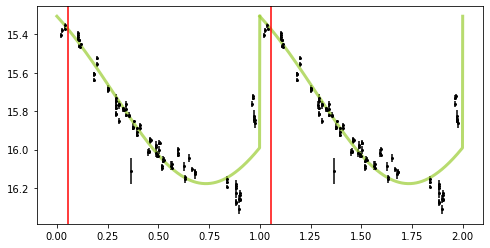

In [11]:
# auto plotting & best-fit curve generation & epoch detection test
star.plot_lc()
x_th,y_th = star.get_bestfit_curve(period=star.period,model='Gaussian',Nterms=1,maxfev=1000000)
epoch_offset = star.get_epoch_offset() # the epoch offset in the unit of [days] (not normalized to phase)

# plot
plt.plot(x_th/star.period,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.plot(x_th/star.period+1,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.axvline(epoch_offset/star.period,color='red')
plt.axvline(epoch_offset/star.period+1,color='red')

/home/sterlingym/anaconda3/envs/base2/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


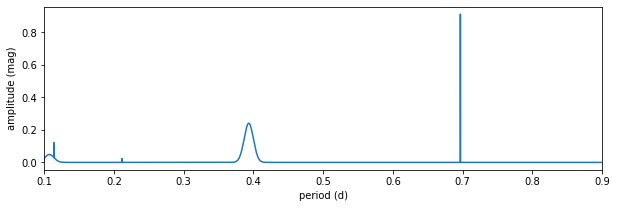

In [14]:
# multi-period detection test
period,spectrum = star.amplitude_spectrum(p_min=0.1,p_max=0.9,N=10,multiprocessing=False)
plt.figure(figsize=(10,3));plt.plot(period,spectrum);plt.xlim(0.1,0.9);plt.xlabel('period (d)');plt.ylabel('amplitude (mag)');plt.show()

# misc (old, to be cleaned)

### Gaussian Mixture

$$ y_i = \sum_j^K p_j \exp{\left(-\frac{\left[(x_i \mod P)-\mu_j\right]^2}{2\sigma_{y,i}^2}\right)}$$

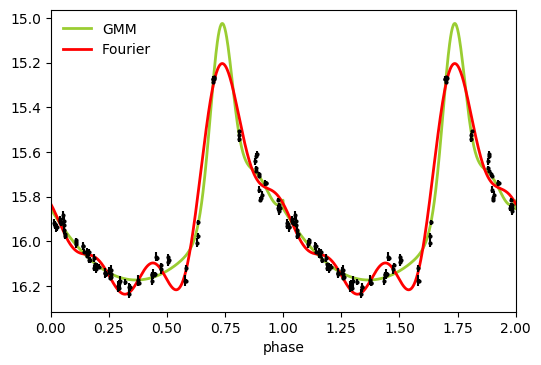

In [8]:
from PIPS.periodogram.models.Gaussian import gaussian, get_bestfit_gaussian
from PIPS.periodogram.models.Fourier import fourier, get_bestfit_Fourier

Nterms = 4
period = star.period
popt_gaussian = get_bestfit_gaussian(star.x,star.y,star.yerr,period,Nterms,return_yfit=False,return_params=True)
popt_fourier = get_bestfit_Fourier(star.x,star.y,star.yerr,period,Nterms,return_yfit=False,return_params=True)

x_th = np.linspace(0,period*2,1000)
y_th_gaussian = gaussian(x_th,period,Nterms,np.array(popt_gaussian))
y_th_fourier = fourier(x_th,period,Nterms,np.array(popt_fourier))

plt.figure(dpi=100)
plt.plot(x_th/period,y_th_gaussian,c='yellowgreen',lw=2,zorder=0,label='GMM')
plt.plot(x_th/period,y_th_fourier,c='red',lw=2,zorder=0,label='Fourier')
plt.errorbar(star.x%period/period,star.y,star.yerr,ms=2,c='k',zorder=1,fmt='o')
plt.errorbar(star.x%period/period+1,star.y,star.yerr,ms=2,c='k',zorder=1,fmt='o')
plt.xlabel('phase');plt.xlim(0,2);plt.legend(frameon=False)
plt.gca().invert_yaxis()

# Linear Algebra Method
Y.Murakami, 1/3/2020

### data
$i$: data point ($x_i, y_i, \sigma_{y,i}$)<br>
$j$: Fourier term index

$$ 
x_{i} = \left(\begin{matrix} x_0\\ x_1\\ \vdots\\ x_n \end{matrix}\right),\ 
y_{i} = \left(\begin{matrix} y_0\\ y_1\\ \vdots\\ y_n \end{matrix}\right),\ 
\sigma_{y,i} = \left(\begin{matrix} \sigma_{y,0}\\ \sigma_{y,1}\\ \vdots\\ \sigma_{y,n} \end{matrix}\right),\
w_{i} = \frac{1}{\Sigma (1/\sigma_{y,i}^2)}\left(\begin{matrix} 1/\sigma_{y,0}^2\\ 1/\sigma_{y,1}^2\\ \vdots\\ 1/\sigma_{y,n}^2 \end{matrix}\right),\
$$

### Weigted mean, floating mean correction (offset)
$$\langle y \rangle = w_i y_i,\ Y_i = y_i - \langle y \rangle$$


### Model Matrix
$$
X_{ij}(\omega) = \left(\begin{matrix}
1 & \sin(\omega x_0) & \sin(2\omega x_0) & \cdots & \sin(K\omega x_0) & \cos(\omega x_0) & \cos(2\omega x_0) & \cdots & \cos(K\omega x_0) \\
1 & \sin(\omega x_1) & \sin(2\omega x_1) & \cdots & \sin(K\omega x_1) & \cos(\omega x_1) & \cos(2\omega x_1) & \cdots & \cos(K\omega x_1) \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \sin(\omega x_n) & \sin(2\omega x_n) & \cdots & \sin(K\omega x_n) & \cos(\omega x_n) & \cos(2\omega x_n) & \cdots & \cos(K\omega x_n) \\
\end{matrix}\right)
$$

### Optimization
$$ X_{ij}\theta_{j} = Y_i \quad \Rightarrow \quad X_{ji}X_{ij}\theta_j = X_{ji}Y_i \quad\Rightarrow\quad \theta_j = (X_{ji}X_{ij})^{-1}X_{ji}Y_i$$

### Best-fit values
$$ Y_{i,\text{fit}} = X_{ij}\theta_j $$

### $\chi^2$ and power calculation
$$ 
\chi^2_i = \frac{(y_i - y_{i,fit})^2}{\sigma_{y,i}^2}, \quad
\chi^2_\text{ref} = \frac{(y_i - \langle y \rangle)^2}{\sigma_{y,i}^2} = \frac{Y_i^2}{\sigma_{y,i}^2}
$$

\begin{align*}
\text{Power}(\omega)_i &= \chi^2_\text{ref} - \chi^2_i \\
&= \frac{y_i^2 - 2y_i\langle y \rangle + \langle y \rangle^2 - y_i^2 + 2y_iy_{i,fit} - y_{i,fit}^2}{\sigma_{y,i}^2} \\
&= \frac{2y_i\left(y_{i,fit} - \langle y \rangle\right) + \langle y \rangle^2 - y_{i,fit}^2}{\sigma_{y,i}^2} \\
&= \frac{2y_i\left(y_{i,fit} - \langle y \rangle\right) + \left(\langle y \rangle + y_{i,fit}\right)\left(\langle y \rangle - y_{i,fit}\right)}{\sigma_{y,i}^2} \\
&= \frac{\left(2y_i - \langle y \rangle - y_{i,fit} \right) \left(y_{i,fit} - \langle y \rangle\right) }{\sigma_{y,i}^2} \\
&= \frac{\left(Y_i + \Delta Y_\text{data-fit}\right)Y_{i,fit}}{\sigma_{y,i}^2}
\end{align*}